<a href="https://colab.research.google.com/github/snig-17/QM-GRUNGE/blob/main/visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Expedition Summaries.csv")

print(df.head())
print(df.columns)

  Year/ Season  Exped Total  Exped Succ  Pct Succ  Total Mbrs  Mbrs AbvBC   \
0      1922 Spr            1           0         0          13          12   
1      1924 Spr            1           0         0          11           9   
2      1933 Spr            1           0         0          16          16   
3      1934 Spr            1           0         0           1           1   
4      1935 Sum            1           0         0           7           7   

  Hired AbvBC  Mbrs Succ  Hired Succ  Mbrs Dead  Hired Dead   
0           30          0           0          0           7  
1           40          0           0          2           2  
2           50          0           0          0           0  
3            2          0           0          1           0  
4           16          0           0          0           0  
Index(['Year/ Season ', 'Exped Total ', 'Exped Succ ', 'Pct Succ ',
       'Total Mbrs ', 'Mbrs AbvBC ', 'Hired AbvBC ', 'Mbrs Succ ',
       'Hired Succ

In [5]:
# Strip whitespace from all column names
df.columns = df.columns.str.strip()

# Rename columns to Python-friendly names
df = df.rename(columns={
    "Year/ Season": "YearSeason",
    "Exped Total": "ExpedTotal",
    "Total Mbrs": "TotalMbrs",
    "Mbrs AbvBC": "MbrsAbvBC",
    "Hired AbvBC": "HiredAbvBC",
    "Mbrs Dead": "MbrsDead",
    "Hired Dead": "HiredDead"
})

# Drop rows where YearSeason is actually the header text
df = df[df["YearSeason"] != "Year/ Season"].copy()

In [7]:
# Split Year and Season
df[["Year", "Season"]] = df["YearSeason"].str.split(" ", expand=True)

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# Drop rows where year could not be parsed
df = df.dropna(subset=["Year"]).copy()
df["Year"] = df["Year"].astype(int)

# Keep requested period
df = df[(df["Year"] >= 1900) & (df["Year"] <= 2025)]

In [8]:
num_cols = [
    "ExpedTotal", "TotalMbrs", "MbrsAbvBC",
    "HiredAbvBC", "MbrsDead", "HiredDead"
]

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Replace negative or impossible values
for c in ["HiredAbvBC", "HiredDead"]:
    df.loc[df[c] < 0, c] = np.nan

In [9]:
year = (
    df.groupby("Year", as_index=False)
      .agg(
          Expeditions=("ExpedTotal", "sum"),
          HiredDeaths=("HiredDead", "sum"),
          HiredAbvBC=("HiredAbvBC", "sum"),
          MeanHiredAbvBC=("HiredAbvBC", "mean"),
      )
)

In [10]:
year["SherpaFatalityRate"] = np.where(
    year["HiredAbvBC"] > 0,
    year["HiredDeaths"] / year["HiredAbvBC"],
    np.nan
)

# 5-year rolling average for visuals
year = year.sort_values("Year")
year["Rate_roll5"] = year["SherpaFatalityRate"].rolling(
    window=5, center=True, min_periods=3
).mean()

print(year.head())


   Year  Expeditions  HiredDeaths  HiredAbvBC  MeanHiredAbvBC  \
0  1922            1          7.0        30.0            30.0   
1  1924            1          2.0        40.0            40.0   
2  1933            1          0.0        50.0            50.0   
3  1934            1          0.0         2.0             2.0   
4  1935            1          0.0        16.0            16.0   

   SherpaFatalityRate  Rate_roll5  
0            0.233333    0.094444  
1            0.050000    0.070833  
2            0.000000    0.056667  
3            0.000000    0.010000  
4            0.000000    0.000000  


In [11]:
bins = [1900, 1979, 1999, 2013, 2025]
labels = ["1900–1979", "1980–1999", "2000–2013", "2014–2025"]

year["Era"] = pd.cut(year["Year"], bins=bins, labels=labels)

desc = (
    year.groupby("Era")
        .agg(
            years=("Year", "count"),
            mean_rate=("SherpaFatalityRate", "mean"),
            median_rate=("SherpaFatalityRate", "median"),
            mean_expeditions=("Expeditions", "mean"),
            mean_hired_abvbc=("MeanHiredAbvBC", "mean")
        )
)

print(desc)


           years  mean_rate  median_rate  mean_expeditions  mean_hired_abvbc
Era                                                                         
1900–1979     29   0.025770     0.000000          1.758621         36.488506
1980–1999     20   0.015279     0.013139         23.500000         47.166667
2000–2013     14   0.002671     0.000990         79.142857        204.916667
2014–2025     11   0.009709     0.002548         63.454545        283.712121


/tmp/ipython-input-1192270672.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year.groupby("Era")


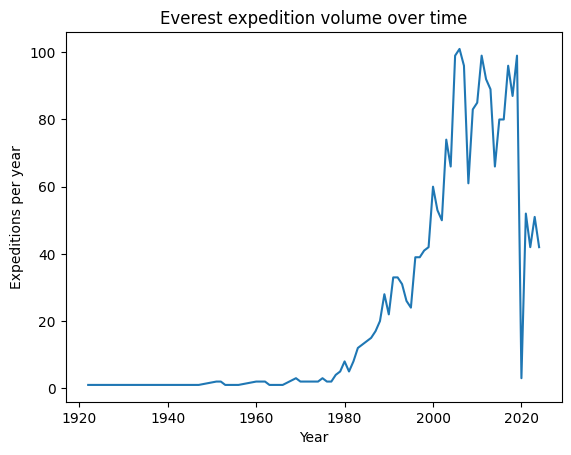

In [12]:
plt.figure()
plt.plot(year["Year"], year["Expeditions"])
plt.xlabel("Year")
plt.ylabel("Expeditions per year")
plt.title("Everest expedition volume over time")
plt.show()


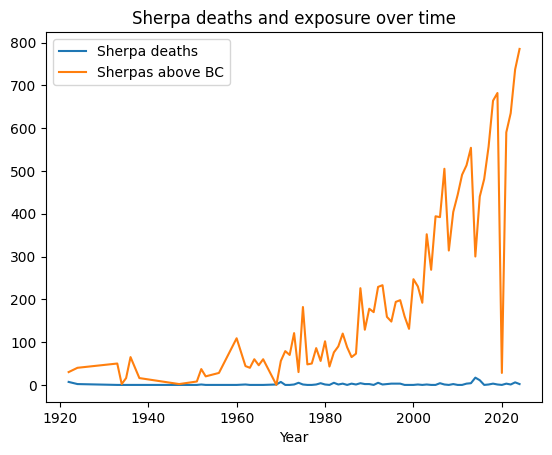

In [13]:
plt.figure()
plt.plot(year["Year"], year["HiredDeaths"], label="Sherpa deaths")
plt.plot(year["Year"], year["HiredAbvBC"], label="Sherpas above BC")
plt.xlabel("Year")
plt.title("Sherpa deaths and exposure over time")
plt.legend()
plt.show()


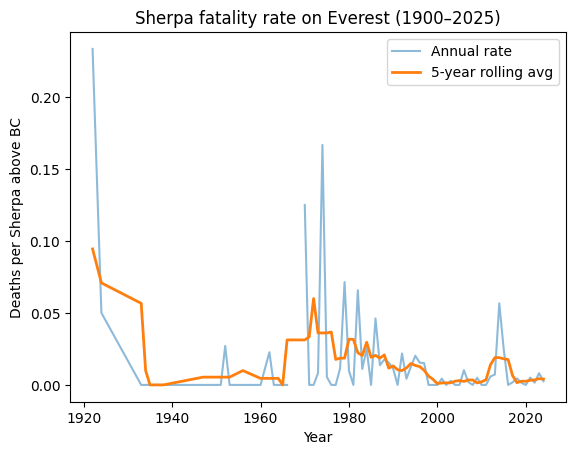

In [14]:
plt.figure()
plt.plot(year["Year"], year["SherpaFatalityRate"], alpha=0.5, label="Annual rate")
plt.plot(year["Year"], year["Rate_roll5"], linewidth=2, label="5-year rolling avg")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Sherpa fatality rate on Everest (1900–2025)")
plt.legend()
plt.show()


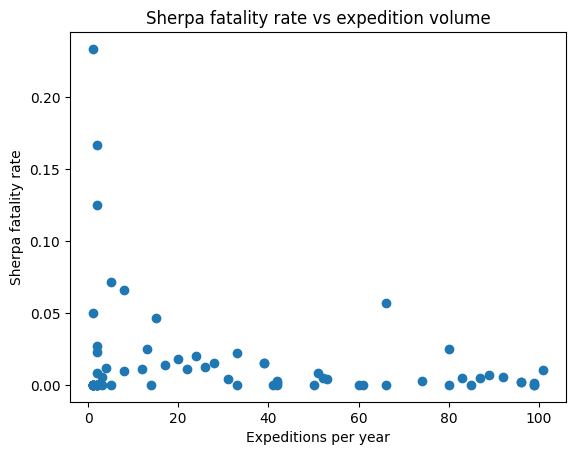

In [15]:
plt.figure()
plt.scatter(year["Expeditions"], year["SherpaFatalityRate"])
plt.xlabel("Expeditions per year")
plt.ylabel("Sherpa fatality rate")
plt.title("Sherpa fatality rate vs expedition volume")
plt.show()